#Deep Learning

In [ ]:
!pip install SimpleITK
!pip install ipyvolume
!pip install diskcache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.8 MB/s eta 0:00:00


In [ ]:
#libraries
import torch
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
from collections import namedtuple #allows to create tuples , accessible using namefields, memory efficient
import functools
import glob #used for searching files recursively
import os
import csv
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ipyvolume as ipv
import time
import matplotlib.animation as animation
import copy
from diskcache import FanoutCache
import argparse
import sys
import datetime
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
import math
from datetime import datetime


#mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#istall zip dataset using curl
!curl -L -o /content/luna16.zip "https://www.kaggle.com/api/v1/datasets/download/avc0706/luna16"

#unzip dataset
!7z x /content/luna16.zip -o/content/luna16_dataset/ "subset0/*" "subset1/*" "subset2/*" "annotations.csv" "candidates.csv"  "sampleSubmission" "seg-lungs-LUNA16" "evaluationScript" "candidates_V2" -y && rm -f /content/luna16.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 32.1G  100 32.1G    0     0   101M      0  0:05:23  0:05:23 --:--:--  119M

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 34507100408 bytes (33 GiB)

Extracting archive: /content/luna16.zip
--
Path = /content/luna16.zip
Type = zip
Physical Size = 34507100408
64-bit = +

  0%      0% 1 - candidates.csv                         0% 2        0% 2 - candidates_V2/candidates_V2.csv        

In [ ]:
#see first few data
!head candidates.csv
!head annotations.csv

#compare values from different csv files
!grep '100225287222365663678666836860.*,1$' candidates.csv
!grep '100225287222365663678666836860' annotations.csv

seriesuid,coordX,coordY,coordZ,class
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-56.08,-67.85,-311.92,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,53.21,-244.41,-245.17,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,103.66,-121.8,-286.62,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-33.66,-72.75,-308.41,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-32.25,-85.36,-362.51,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-26.65,-203.07,-165.07,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-74.99,-114.79,-311.92,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-16.14,-248.61,-239.55,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,135.89,-141.41,-252.2,0


##Data Preprocessing

In [ ]:
#define namedtuples
XyzTuple = namedtuple('XyzTuple' , ['x', 'y', 'z'])
IrcTuple = namedtuple('IrcTuple' , ['index', 'row', 'col'])


#utility function to convert data from mm to voxels and vice versa
def irc2xyz (coord_irc, origini_xyz, vxSize_xyz, direction_a):
    """
    convert voxel coordinate into mm coordinates
    """
    cri_a = np.array(coord_irc)[::-1]  #flip the array to match xyz coordinates
    origin_a = np.array(origini_xyz)  #get a copy of the origin of the coordinate system in mm
    vxSize_a = np.array(vxSize_xyz) #get a copy of the voxel coordinates

    coords_xyz =  (direction_a @ (cri_a * vxSize_a)) + origin_a

    return XyzTuple(*coords_xyz) # * is used to unpack the list of coordinates


def xyz2irc (coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    """
    convert mm coordinates into voxel coordinates
    """

    xyz_a = np.array(coord_xyz)[::-1]
    origini_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)

    cri_a = (coord_xyz - origini_a) @ np.linalg.inv(direction_a) / vxSize_a
    cri_a = np.round(cri_a) #round to the nearrest integer

    return IrcTuple(int(cri_a[2]) , int(cri_a[1]) , int(cri_a[0]))


def getCache(scope_str):
    return FanoutCache( #disk based cache
        'data-unversioned/cache/' + scope_str,
        shards=64,       # Split into 64 sub-databases
        timeout=1,       # 1-second lock timeout
        size_limit=3e11, # ~300 GB max storage
    )
raw_cache = getCache('part2ch10_raw') #this will create a persistent cache in the current workfolder
# raw_cache.clear()  #this clear disk cache


# # Test parameters
# coord_irc = IrcTuple(index=10, row=20, col=30)  # Original voxel coordinates
# origin_xyz = (-200, -150, -100)                # Scanner origin in mm
# vxSize_xyz = (0.76, 0.76, 2.5)                # Voxel size (x,y,z) in mm
# direction_a = np.identity(3)                   # No rotation (identity matrix)

# #test
# xyz_coords = irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a)
# print(f"IRC {coord_irc} → XYZ {xyz_coords}")

# reconstructed_irc = xyz2irc(xyz_coords, origin_xyz, vxSize_xyz, direction_a)
# print(f"XYZ {xyz_coords} → IRC {reconstructed_irc}")

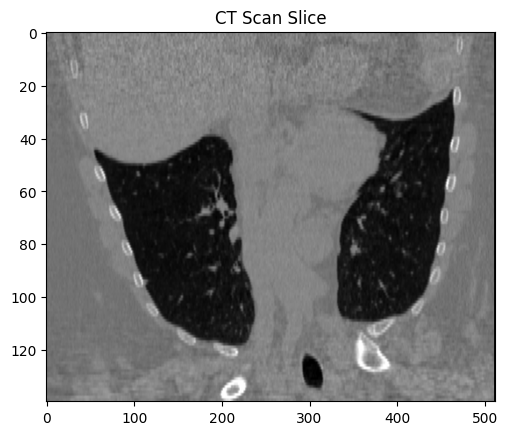

(tensor([[[[-732., -810., -863.,  ..., -848., -865., -890.],
           [-767., -826., -855.,  ..., -908., -896., -879.],
           [-807., -859., -848.,  ..., -898., -903., -897.],
           ...,
           [-874., -869., -839.,  ..., -159., -121., -104.],
           [-923., -930., -911.,  ..., -115., -104., -117.],
           [-898., -898., -901.,  ...,  -89.,  -93., -129.]],
 
          [[-776., -779., -860.,  ..., -852., -875., -874.],
           [-839., -834., -889.,  ..., -875., -894., -898.],
           [-861., -857., -882.,  ..., -838., -865., -889.],
           ...,
           [-862., -932., -917.,  ..., -111.,  -94., -101.],
           [-896., -918., -898.,  ...,  -16.,    1.,  -41.],
           [-875., -894., -881.,  ...,  -55.,  -47.,  -83.]],
 
          [[-854., -898., -884.,  ..., -886., -878., -857.],
           [-856., -876., -865.,  ..., -869., -880., -884.],
           [-841., -859., -881.,  ..., -857., -844., -832.],
           ...,
           [-744., -880., -873.

In [ ]:
CandidateInfoTuple = namedtuple(  #it takes 2 arguments
    'CandidateInfoTuple', #the name of the tuple
    'isNodule_bool, diameter_mm, series_uid, center_xyz', # a list of fields name
)

#build a list of this named tuples
@functools.lru_cache(1) #this will cache in memory the result of the function for a set of inputs
def getCandidateInfoList(requireOnDisk_bool=True):

    #get all the mhd file (the ct scans) to check which one we already have in memory and which we still have to download
    mhd_list = glob.glob("./luna16_dataset/subset*/**/*.mhd")

    #extract file name
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list} #set comprehension ,fast lookhups , remove duplicates

    diameter_dict = {}

    #read annottions file
    with open('./luna16_dataset/annotations.csv', 'r') as file:
        for row in list(csv.reader(file))[1:]: #skips the header
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid , []).append((annotationCenter_xyz, annotationDiameter_mm)) #populate the dictionary


    candidateInfo_list = []
    #read candidates file
    with open('./luna16_dataset/candidates.csv', 'r') as file:
        for row in list(csv.reader(file))[1:]: #skip the header
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue  #skip the row if not present on disk

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz =  tuple([float(x) for x in row[1:4]])
            candidateDiameter_mm = 0.0


            for annotation_tuple in diameter_dict.get(series_uid, []):  #if the key is missing return an empty lsit
                annotationCenter_xyz , annotationDiameter_mm = annotation_tuple


                for i in range (3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])  #absolute difference between the center form the 2 csv files

                    if delta_mm > annotationDiameter_mm/4:
                        break


                else: #executeonly if the for loop doesnt break
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            #append to the list
            candidateInfo_list.append(
                CandidateInfoTuple(isNodule_bool, candidateDiameter_mm, series_uid, candidateCenter_xyz)
            )

    #sort the list
    candidateInfo_list.sort(reverse=True)

    return candidateInfo_list



#convert raw CT data (.mhd and .raw files) into python objetcs
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(f'/content/luna16_dataset/subset*/**/{series_uid}.mhd')[0]  #glob return a list , get the first element of the list
        ct_mhd = sitk.ReadImage(mhd_path) #create a SimpleITK image object
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32) #convert to numpy array
        ct_a = np.clip(ct_a, -1000, 1000)  #clip the array to certain HU values

        #assign cleaned data to the class
        self.series_uid = series_uid  #series identifier
        self.hu_a = ct_a  #ct scan array
        self.vxSize_xyz = ct_mhd.GetSpacing()  #voxel sizes
        self.origin_xyz = ct_mhd.GetOrigin() # origini of the patient coordinates
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3,3) #patient orientation

    def visualize (self, slice = 229):
        #visualize a slice of the ct scan
        aspect_ratio = self.vxSize_xyz[2] / self.vxSize_xyz[0]
        ct_slice = self.hu_a[:, 229, :]
        plt.imshow(ct_slice, cmap='gray', aspect=aspect_ratio)
        plt.title("CT Scan Slice")
        plt.show()


    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(center_xyz, self.origin_xyz , self.vxSize_xyz, self.direction_a) #cnvert center into voxel coordinates
        slice_list = [] #will contain the voxels around the noudle for each slice

        for axis, center_val in enumerate(center_irc):
            start_index = int(center_val - width_irc[axis]/2)
            end_index = int(center_val + width_irc[axis]/2)

            #check for edge cases where the nodule is at the edges
            if start_index < 0:
                start_index =0
                end_index = int(width_irc[axis])

            elif end_index > self.hu_a.shape[axis]:
                end_index = self.hu_a.shape[axis]
                start_index = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_index ,end_index))  #slice is an object


        ct_chunk = self.hu_a[tuple(slice_list)] #nodule voxels
        return ct_chunk, center_irc


@functools.lru_cache(1, typed = True) #int and float input will be treated as different inputs
def getCt(series_uid):
    return Ct(series_uid)

# getCt.cache_clear() #this clear memory cache

@raw_cache.memoize(typed=True) #int and float input will be treated as different inputs
def getCtRawCandidate(series_uid, center_xyz , width_irc):
    ct = getCt(series_uid)
    ct_nodule , center_irc = ct.getRawCandidate(center_xyz , width_irc)
    return ct_nodule, center_irc



class LunaDataset(Dataset):
    def __init__(self, series_uid = None, val_stride = 0, isValSet_bool = False):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())  #copy the return list so that the cached list wont be modified

        if series_uid:
            self.candidateInfo_list = [x for x in self.candidateInfo_list if x == series_uid]  #subset of selected series_uid

        if isValSet_bool and val_stride > 0:
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]  #subsample every nth candidate

        elif val_stride >0:
            del self.candidateInfo_list[::val_stride]  #delete every nth candidate

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, index):
        candidate_tuple = self.candidateInfo_list[index] #get the candidate tuple

        #define a fixed dimension to store the nodule arrays (since NN require fixed inputs dimension)
        width_irc = (32, 48, 48)

        #get the nodule voxels
        candidate_a, center_irc = getCtRawCandidate(candidate_tuple.series_uid, candidate_tuple.center_xyz, width_irc)  #get Ct object

        #convert numpy arrays into torch tensors
        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0) #unsquueze is needed to add a batch dimension to the image

        #create label tensor
        pos_t = torch.tensor([not candidate_tuple.isNodule_bool, candidate_tuple.isNodule_bool], dtype= torch.long)  #one-hot encoded lable (first position: not a noduel, secondposition: nodule)


        return (candidate_t, pos_t,candidate_tuple.series_uid,torch.tensor(center_irc),)


ct_objetc = Ct('1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058')
ct_objetc.visualize()

#create dataset
LunaDataset()[0]

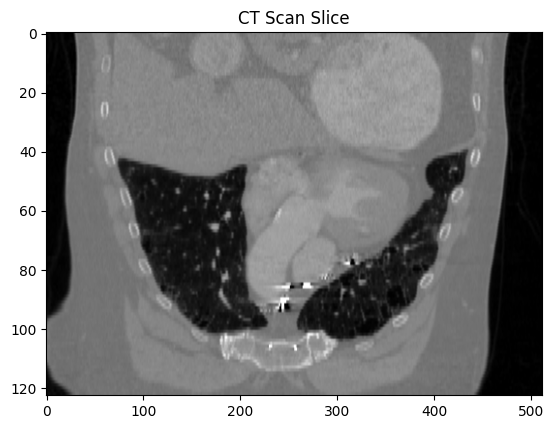

In [ ]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=True)
positiveInfo_list = [x for x in candidateInfo_list if x.isNodule_bool == True]
diameter_list = [x[1] for x in positiveInfo_list]

# for i in range(0, len(diameter_list), 100):
#     print('{:4} {:4.1f} mm'.format(i, diameter_list[i]))

getCt(positiveInfo_list[0].series_uid).visualize(slice = 5)

##Neural Network

In [ ]:
#a nn typically consist of a tail , body and head, the body consists of a set of layers that repeat

class LunaBlock(nn.Module):
    def __init__(self, in_channels,  conv_channels):
        super().__init__()

        #define layers of the body
        self.conv1 = nn.Conv3d(in_channels, conv_channels, kernel_size=3, padding=1,  bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(conv_channels, conv_channels, kernel_size=3, padding=1,  bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2,2)

    def farward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out)
        return self.maxpool(block_out)



class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()

        #define the layers of the model

        #tail layer
        self.tail_normalization = nn.BatchNorm3d(in_channels , conv_channels)

        #body layers
        self.block1 = LunaBlock(in_channels, conv_channels )
        self.block2 = LunaBlock(in_channels  , conv_channels *2)
        self.block3 = LunaBlock(in_channels*2, conv_channels*4)
        self.block4 = LunaBlock(in_channels*4, conv_channels*8)

        #head layer
        self.head_linear =  nn.Linear(1152, 2) #64*2*3*3  (64 is the channels dimension)
        self.head_softmax = nn.Softmax(dim = 1)


    def farward(self, input_batch):
        bn_output = self.tail_normalization(input_batch)

        block_out = self.block1(bn_output)
        block_out = self.block2(block_out)
        block_out = self.block3(block_out)
        block_out = self.block4(block_out)

        #reshape the output since the fully connected layer exxpect a 2d tensor
        conv_flat = block_out.view(block_out.size(0), -1) #condense all the other dimensions except the first one (which represent the number of batch)

        linear_output = self.head_linear(conv_flat)
        return linear_output, self.head_softmax(linear_output)  #the nn return both raw logits and probabilities (only tp imporve interpretability)


    def _init_weights(self):
        for m in self.modules(): #iterate over each layer
            if type(m) in {nn.Linear, nn.Conv3d}: #initialize this 2 type of layers
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out', nonlinearity='relu')  #initial weights with a normal distribution scaled by the layer’s fan-out (number of output units)

                if m.bias is not None: #biases are initialized to small random values near zero
                    fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)




##Training application

In [ ]:
METRICS_SIZE = 3


#encapsulate in a class the application which will be performing the training
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:] #if the arguments where not provided get from the command line

        #define a parser to parse the command line arguments provided
        parser = argparse.ArgumentParser()

        parser.add_argument(
            '--num_workers',
            help='Number of worker processes for background data loading',
            default=8,
            type=int
        )

        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=32,
            type=int,
        )
        parser.add_argument('--epochs',
            help='Number of epochs to train for',
            default=1,
            type=int,
        )

        parser.add_argument('--tb-prefix',
            default='p2ch11',
            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
        )

        parser.add_argument('comment',
            help="Comment suffix for Tensorboard run.",
            nargs='?',
            default='dwlpt',
        )

        #store the command line arguments
        self.cli_args = parser.parse_known_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')  #timestamp

        self.use_cuda = torch.cuda.is_available() #check if cuda is available
        self.device = torch.device('cuda' if self.use_cuda else 'cpu')  #define where to perform the training

        #initialization
        self.model = self.initModel()  #neural network to be trained
        self.optimizer = self.intiOptimizer()


    def initModel(self):
        model = LunaModel() #neural network

        if self.use_cuda:
            if torch.cuda.device_count() > 1:  #if more than one gpu is availabe
                model = nn.DataParallel(model)  #wrapper that will distribute the work acorss all available gpu

            model.to(self.device) #move the model parameters to the gpu

        return model

    def initiOptimizer(self):
        return SGD(self.model.parameters , lr = 0.001 , momentum= 0.99)


    def initTrainDl(self): #initialize the train dataloader
        train_ds = LunaDataset(val_stride=10 , isValSet_bool=False) #get the training data

        #get batch size
        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count() #this enable each gpu to work simultaneusly on a size equal to the size of hte batch defined

        #define the train dataloader
        train_dl = DataLoader(train_ds,
                              batch_size=batch_size,
                              num_workers=self.cli_args.num_workers, #num of parallel process to load the data to the CPU
                              pin_memory=self.use_cuda)  #fasten transfer of data from cpu to gpu

        return train_dl

    def intiValDl(self):
        val_ds = LunaDataset(val_stride=10, isValSet_bool=True)
        batch_size = self.cli_args.count
        if self.use_cuda:
            batch_size *= torch.cuda.device_count

        val_dl = DataLoader(val_ds, batch_size, num_workers=self.cli_args.num_workers, pin_memory=self.use_cuda)

        return val_dl


    def main (self):
        #get dataloaders
        train_dl = self.initTrainDl
        val_dl = self.intiValDl

        #train the model
        for epoch in self.cli_args.epoch:
            trainMetrics = self.doTraining(epoch, train_dl) #perform training steps on the training loader
            self.logMetrics(epoch, 'trt' , trainMetrics)  #log the results

            #do the same for the validation loader
            valMetrics = self.doTraining(epoch, val_dl) #perform training steps on the validation loader
            self.logMetrics(epoch, 'val' , valMetrics)  #log the results



    def doTraining(self, epoch, train_dl):
        """
        training steps: reset gradients, farward pass, compute loss, backward pass, update model weights
        """
        self.model.train() #put the model in training mode
        trainMetrics = torch.zeros(METRICS_SIZE, #number of metrics we want to track
                                   len(train_dl),
                                   device= self.device)


        #train for each batch
        for batch_index , batch_tuple in enumerate(train_dl):
            #reset gradients
            self.optimizer.zero_grad()

            #farward pass and compute the loss
            loss = self.computeBatchLoss(batch_index, batch_tuple, train_dl.batch_size, trainMetrics)

            #backward pass
            loss.backward()

            #update model weights
            self.optimizer.step()

        self.totalTrainingSample_count += len(train_dl) #count total number of training sample processed during training


        return trainMetrics.to('cpu') #move metrics back to cpu


if __name__ == '__main__':
    LunaTrainingApp.main() #main is the entry point of the app



Namespace(word='ciao')
ciao
